# 02 · Cleaning & Feature Engineering
* Initial EDA: Summary statistics
* Data Cleaning: Data quality checks - data types, missing values, duplicates, outliers
* EDA: distributions, correlations, trends, patterns, anomalies
* Feature engineering: RFM, customer segments, product categories, time-based features

* Documentation: data dictionary, code comments, README

In [435]:
import pandas as pd, numpy as np, json, pathlib
import matplotlib.pyplot as plt, seaborn as sns


DATA = pathlib.Path("../data")
products = pd.read_csv(DATA/"products_raw.csv")
users = pd.read_csv(DATA/"users_raw.csv")
carts = pd.read_csv(DATA/"carts_raw.csv")
categories = pd.read_csv(DATA/"categories.csv")

## 2.1. Data Cleaning

- Incorrect Data Types
- Summary Statistics
- Handling Missing Values
- Outliers
- Duplicates

In [436]:
# Define outlier detection function IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

### 2.1.1. Clean 'Users' Table

In [437]:
# Normalize users (handles JSON-like strings)
def safe_to_json(x):
    if isinstance(x, str):
        try:
            return json.loads(x.replace("'", '"'))
        except Exception:
            return None
    return x if isinstance(x, dict) else None

users_name = users["name"].apply(safe_to_json)
users_addr = users["address"].apply(safe_to_json)

users_clean = pd.DataFrame({
    "user_id": users["id"],
    "email": users.get("email", pd.Series([None]*len(users))),
    "username": users.get("username", pd.Series([None]*len(users))),
    "firstname": users_name.apply(lambda d: d.get("firstname") if isinstance(d, dict) else None),
    "lastname": users_name.apply(lambda d: d.get("lastname") if isinstance(d, dict) else None),
    "city": users_addr.apply(lambda d: d.get("city") if isinstance(d, dict) else None),
    "zipcode": users_addr.apply(lambda d: d.get("zipcode") if isinstance(d, dict) else None),
})

# Check data types, missing values, duplicates, basic stats
users_clean.info()
print('-------------------')
print(users_clean.isnull().sum())
print('-------------------')
print('Number of duplicates:', users_clean.duplicated().sum())
print('-------------------')
print(users_clean.select_dtypes(include=[np.number]).describe())  
print('-------------------')

# Clean 'city' column: title case, strip whitespace
users_clean['city'] = users_clean['city'].str.title().str.strip()
users_clean['city'].value_counts().head(10)

# Save curated
users_clean.to_csv(DATA/"users.csv", index=False)
print("Saved users.csv in", DATA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    10 non-null     int64 
 1   email      10 non-null     object
 2   username   10 non-null     object
 3   firstname  10 non-null     object
 4   lastname   10 non-null     object
 5   city       10 non-null     object
 6   zipcode    10 non-null     object
dtypes: int64(1), object(6)
memory usage: 692.0+ bytes
-------------------
user_id      0
email        0
username     0
firstname    0
lastname     0
city         0
zipcode      0
dtype: int64
-------------------
Number of duplicates: 0
-------------------
        user_id
count  10.00000
mean    5.50000
std     3.02765
min     1.00000
25%     3.25000
50%     5.50000
75%     7.75000
max    10.00000
-------------------
Saved users.csv in ../data


### 2.1.2. Create & Clean 'Transactions' Table

In [438]:
# Explode carts -> transaction lines
carts["date"] = pd.to_datetime(carts["date"], errors="coerce")
lines = []
for _, row in carts.iterrows():
    prods = safe_to_json(row["products"])
    if isinstance(prods, list):
        for it in prods:
            lines.append({
                "cart_id": row["id"],
                "user_id": row["userId"],
                "date": row["date"],
                "product_id": it.get("productId"),
                "quantity": it.get("quantity", 1)
            })
tx = pd.DataFrame(lines)

# Join price & compute revenue
tx = tx.merge(products[["id","title","category","price"]], left_on="product_id", right_on="id", how="left")
tx["line_revenue"] = tx["quantity"] * tx["price"]
tx = tx.drop(columns=["id"]).sort_values("date")

# Check data types, missing values, basic stats
tx.info()
print('-------------------')
print(tx.isna().sum()) 
print('-------------------')
print('Number of duplicates:', tx.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 8 to 2
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   cart_id       14 non-null     int64              
 1   user_id       14 non-null     int64              
 2   date          14 non-null     datetime64[ns, UTC]
 3   product_id    14 non-null     int64              
 4   quantity      14 non-null     int64              
 5   title         14 non-null     object             
 6   category      14 non-null     object             
 7   price         14 non-null     float64            
 8   line_revenue  14 non-null     float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(4), object(2)
memory usage: 1.1+ KB
-------------------
cart_id         0
user_id         0
date            0
product_id      0
quantity        0
title           0
category        0
price           0
line_revenue    0
dtype: int64
------------------

In [439]:
# Summary statistics for numeric columns
print(tx.select_dtypes(include=[np.number]).describe())

         cart_id    user_id  product_id   quantity       price  line_revenue
count  14.000000  14.000000   14.000000  14.000000   14.000000     14.000000
mean    3.428571   2.500000    5.714286   3.000000  110.944286    335.090714
std     2.064882   1.951331    5.195095   2.541956  173.754953    420.111207
min     1.000000   1.000000    1.000000   1.000000    9.850000      9.850000
25%     2.000000   1.000000    1.250000   1.000000   22.300000     32.725000
50%     3.000000   2.000000    4.000000   2.000000   86.500000    218.950000
75%     5.000000   3.000000    8.750000   4.000000  109.950000    415.350000
max     7.000000   8.000000   18.000000  10.000000  695.000000   1390.000000


In [440]:
# Detect outliers
for column in tx.select_dtypes(include=[np.number]).columns:
    outliers = detect_outliers_iqr(tx, column)
    if not outliers.empty:
        print(f"Outliers detected in '{column}':")
        print(outliers)

# Since the outliers are valid (e.g. high-value purchases), we keep them for analysis

# Save curated
tx.to_csv(DATA/"transactions.csv", index=False)

Outliers detected in 'user_id':
    cart_id  user_id                      date  product_id  quantity  \
13        7        8 2020-03-01 00:00:00+00:00          18         1   

                                          title          category  price  \
13  MBJ Women's Solid Short Sleeve Boat Neck V   women's clothing   9.85   

    line_revenue  
13          9.85  
Outliers detected in 'quantity':
   cart_id  user_id                      date  product_id  quantity  \
4        2        1 2020-01-02 00:00:00+00:00           1        10   

                                               title        category   price  \
4  Fjallraven - Foldsack No. 1 Backpack, Fits 15 ...  men's clothing  109.95   

   line_revenue  
4        1099.5  
Outliers detected in 'price':
   cart_id  user_id                      date  product_id  quantity  \
5        2        1 2020-01-02 00:00:00+00:00           5         2   

                                               title  category  price  \
5  John Hardy

### 2.1.3. Clean 'Products' table

In [441]:
# Check products table data types, missing values
products.info()
print('-------------------')
print(products.isna().sum())
print('-------------------')
print('Number of duplicates:', products.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           20 non-null     int64  
 1   title        20 non-null     object 
 2   price        20 non-null     float64
 3   description  20 non-null     object 
 4   category     20 non-null     object 
 5   image        20 non-null     object 
 6   rating       20 non-null     object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.2+ KB
-------------------
id             0
title          0
price          0
description    0
category       0
image          0
rating         0
dtype: int64
-------------------
Number of duplicates: 0


In [442]:
# Explode 'rating' column into two separate columns (rate, count)
products["rating"] = products["rating"].apply(safe_to_json)
products["rating_rate"] = products["rating"].apply(lambda d: d.get("rate") if isinstance(d, dict) else None)
products["rating_count"] = products["rating"].apply(lambda d: d.get("count") if isinstance(d, dict) else None)
products.drop(columns=["rating"], inplace=True)
products.head() 

,id,title,price,description,category,image,rating_rate,rating_count
0,1,"Fjallraven - Foldsack No. 1 Backpack, Fits 15 ...",109.95,Your perfect pack for everyday use and walks i...,men's clothing,https://fakestoreapi.com/img/81fPKd-2AYL._AC_S...,3.9,120
1,2,Mens Casual Premium Slim Fit T-Shirts,22.30,"Slim-fitting style, contrast raglan long sleev...",men's clothing,https://fakestoreapi.com/img/71-3HjGNDUL._AC_S...,4.1,259
2,3,Mens Cotton Jacket,55.99,great outerwear jackets for Spring/Autumn/Wint...,men's clothing,https://fakestoreapi.com/img/71li-ujtlUL._AC_U...,4.7,500
3,4,Mens Casual Slim Fit,15.99,The color could be slightly different between ...,men's clothing,https://fakestoreapi.com/img/71YXzeOuslL._AC_U...,2.1,430
4,5,John Hardy Women's Legends Naga Gold & Silver ...,695.00,"From our Legends Collection, the Naga was insp...",jewelery,https://fakestoreapi.com/img/71pWzhdJNwL._AC_U...,4.6,400


In [443]:
# Summary statistics for numeric columns
print(products.select_dtypes(include=[np.number]).describe())

             id       price  rating_rate  rating_count
count  20.00000   20.000000    20.000000     20.000000
mean   10.50000  162.046000     3.560000    286.800000
std     5.91608  272.220532     0.961578    162.751538
min     1.00000    7.950000     1.900000     70.000000
25%     5.75000   15.240000     2.900000    143.750000
50%    10.50000   56.490000     3.700000    254.500000
75%    15.25000  110.962500     4.525000    400.000000
max    20.00000  999.990000     4.800000    679.000000


In [444]:
# Check for outliers
for column in products.select_dtypes(include=[np.number]).columns:
    outliers = detect_outliers_iqr(products, column)
    if not outliers.empty:
        print(f"Outliers detected in '{column}':")
        print(outliers)

# Since the outliers are valid (e.g. high-priced products), we keep them for analysis

# Save curated
products.to_csv(DATA/"products.csv", index=False)
print("Saved transactions.csv in", DATA)

Outliers detected in 'price':
    id                                              title   price  \
4    5  John Hardy Women's Legends Naga Gold & Silver ...  695.00   
12  13  Acer SB220Q bi 21.5 inches Full HD (1920 x 108...  599.00   
13  14  Samsung 49-Inch CHG90 144Hz Curved Gaming Moni...  999.99   

                                          description     category  \
4   From our Legends Collection, the Naga was insp...     jewelery   
12  21. 5 inches Full HD (1920 x 1080) widescreen ...  electronics   
13  49 INCH SUPER ULTRAWIDE 32:9 CURVED GAMING MON...  electronics   

                                                image  rating_rate  \
4   https://fakestoreapi.com/img/71pWzhdJNwL._AC_U...          4.6   
12  https://fakestoreapi.com/img/81QpkIctqPL._AC_S...          2.9   
13  https://fakestoreapi.com/img/81Zt42ioCgL._AC_S...          2.2   

    rating_count  
4            400  
12           250  
13           140  
Saved transactions.csv in ../data


### 2.1.4. Create 'RFM' Table

In [445]:
# RFM - Recency, Frequency, Monetary
# Recency: days since last purchase
# Frequency: number of unique carts (orders)
# Monetary: total revenue
# AOV: Average Order Value (monetary / frequency)
rfm = (tx.groupby("user_id")
         .agg(last_purchase=("date","max"),
              frequency=("cart_id","nunique"),
              monetary=("line_revenue","sum"),
              aov=("line_revenue","mean"))  # Average Order Value
         .reset_index())
rfm["recency_days"] = (tx["date"].max() - rfm["last_purchase"]).dt.days
rfm = rfm.drop(columns=["last_purchase"])


rfm.to_csv(DATA/"user_rfm.csv", index=False)
print("Saved transactions.csv, users.csv, user_rfm.csv in", DATA)

Saved transactions.csv, users.csv, user_rfm.csv in ../data


In [446]:
# Check RFM table data types, missing values, basic stats
rfm.info()
print('-------------------')
print(rfm.isna().sum())   
print('-------------------')
print('Number of duplicates:', rfm.duplicated().sum())
print('-------------------')
print(rfm.select_dtypes(include=[np.number]).describe())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       5 non-null      int64  
 1   frequency     5 non-null      int64  
 2   monetary      5 non-null      float64
 3   aov           5 non-null      float64
 4   recency_days  5 non-null      int64  
dtypes: float64(2), int64(3)
memory usage: 332.0 bytes
-------------------
user_id         0
frequency       0
monetary        0
aov             0
recency_days    0
dtype: int64
-------------------
Number of duplicates: 0
-------------------
        user_id  frequency     monetary         aov  recency_days
count  5.000000   5.000000     5.000000    5.000000      5.000000
mean   3.600000   1.400000   938.254000  229.636667      0.800000
std    2.701851   0.547723  1379.074384  209.347395      0.447214
min    1.000000   1.000000     9.850000    9.850000      0.000000
25%    2.000000   1.000000 

In [447]:
# Check for outliers
for column in rfm.select_dtypes(include=[np.number]).columns:
    outliers = detect_outliers_iqr(rfm, column)
    if not outliers.empty:
        print(f"Outliers detected in '{column}':")
        print(outliers) 

# Since the outliers are valid (e.g. high-value customers), we keep them for analysis   

# Save curated
rfm.to_csv(DATA/"user_rfm.csv", index=False)
print("Saved transactions.csv, users.csv, user_rfm.csv in", DATA)

Outliers detected in 'user_id':
   user_id  frequency  monetary   aov  recency_days
4        8          1      9.85  9.85             1
Outliers detected in 'monetary':
   user_id  frequency  monetary     aov  recency_days
0        1          2   3376.74  562.79             0
Outliers detected in 'aov':
   user_id  frequency  monetary     aov  recency_days
0        1          2   3376.74  562.79             0
Outliers detected in 'recency_days':
   user_id  frequency  monetary     aov  recency_days
0        1          2   3376.74  562.79             0
Saved transactions.csv, users.csv, user_rfm.csv in ../data


## 2.2. Feature Engineering

In [448]:
# Merge product ratings & transactions into a new DataFrame
merge_df = pd.merge(tx, products[['id','rating_rate','rating_count']], left_on="product_id", right_on='id', how="left")
merge_df.drop(columns=['id'], inplace=True)

In [449]:
# Merge user info into the DataFrame
merge_df = pd.merge(merge_df, users_clean[['user_id', 'city','zipcode']],
                    left_on='user_id', right_on='user_id', how='left')
merge_df = pd.merge(merge_df, rfm,
                    left_on='user_id', right_on='user_id',how='left')

In [450]:
# Create date-related features
# Exclude 'year' & 'quarter' since they have zero variance
merge_df['month'] = merge_df['date'].dt.month
merge_df['day'] = merge_df['date'].dt.day
merge_df['dayofweek'] = pd.to_datetime(merge_df['date']).dt.dayofweek
merge_df['is_weekend'] = merge_df['dayofweek'].isin([5,6]).astype(int)

merge_df.drop(columns=['date'], inplace=True, errors='ignore')

In [451]:
merge_df.drop(columns=['title'], inplace=True, errors='ignore')
merge_df.to_csv(DATA/"merged_data.csv", index=False)
print("Saved merged_data.csv in", DATA)

Saved merged_data.csv in ../data


## 2.3. Exploratory Data Analysis

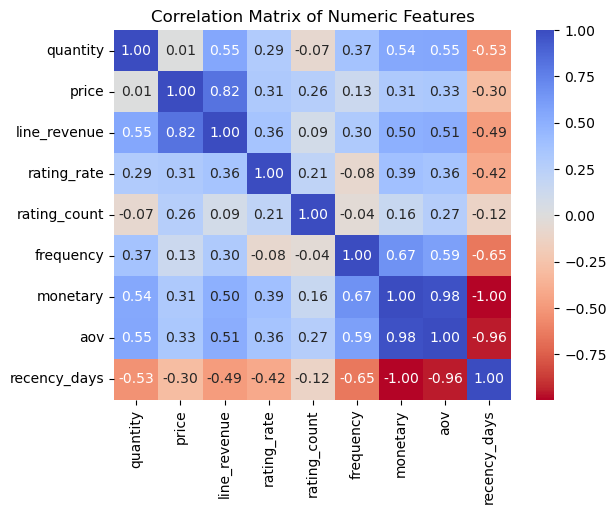

In [452]:
# Check correlations between numeric variables
numeric_vars = ['quantity','price','line_revenue','rating_rate','rating_count','frequency','monetary','aov','recency_days']

sns.heatmap(merge_df[numeric_vars].corr(), annot=True, fmt=".2f", cmap="coolwarm_r")
plt.title("Correlation Matrix of Numeric Features")
plt.show() 

# Since 'line_revenue' was built from 'price' and 'quantity'
# the high correlations are expected, but not meaningful
# so we may drop 'line_revenue' later if needed

# Positive correlation: monetary & frequency (loyal customers spend more)
# Negative correlation: recency & frequency/monetary (recent customers spend more)
# Negative correlation: recency & aov (recent customers have higher AOV)    

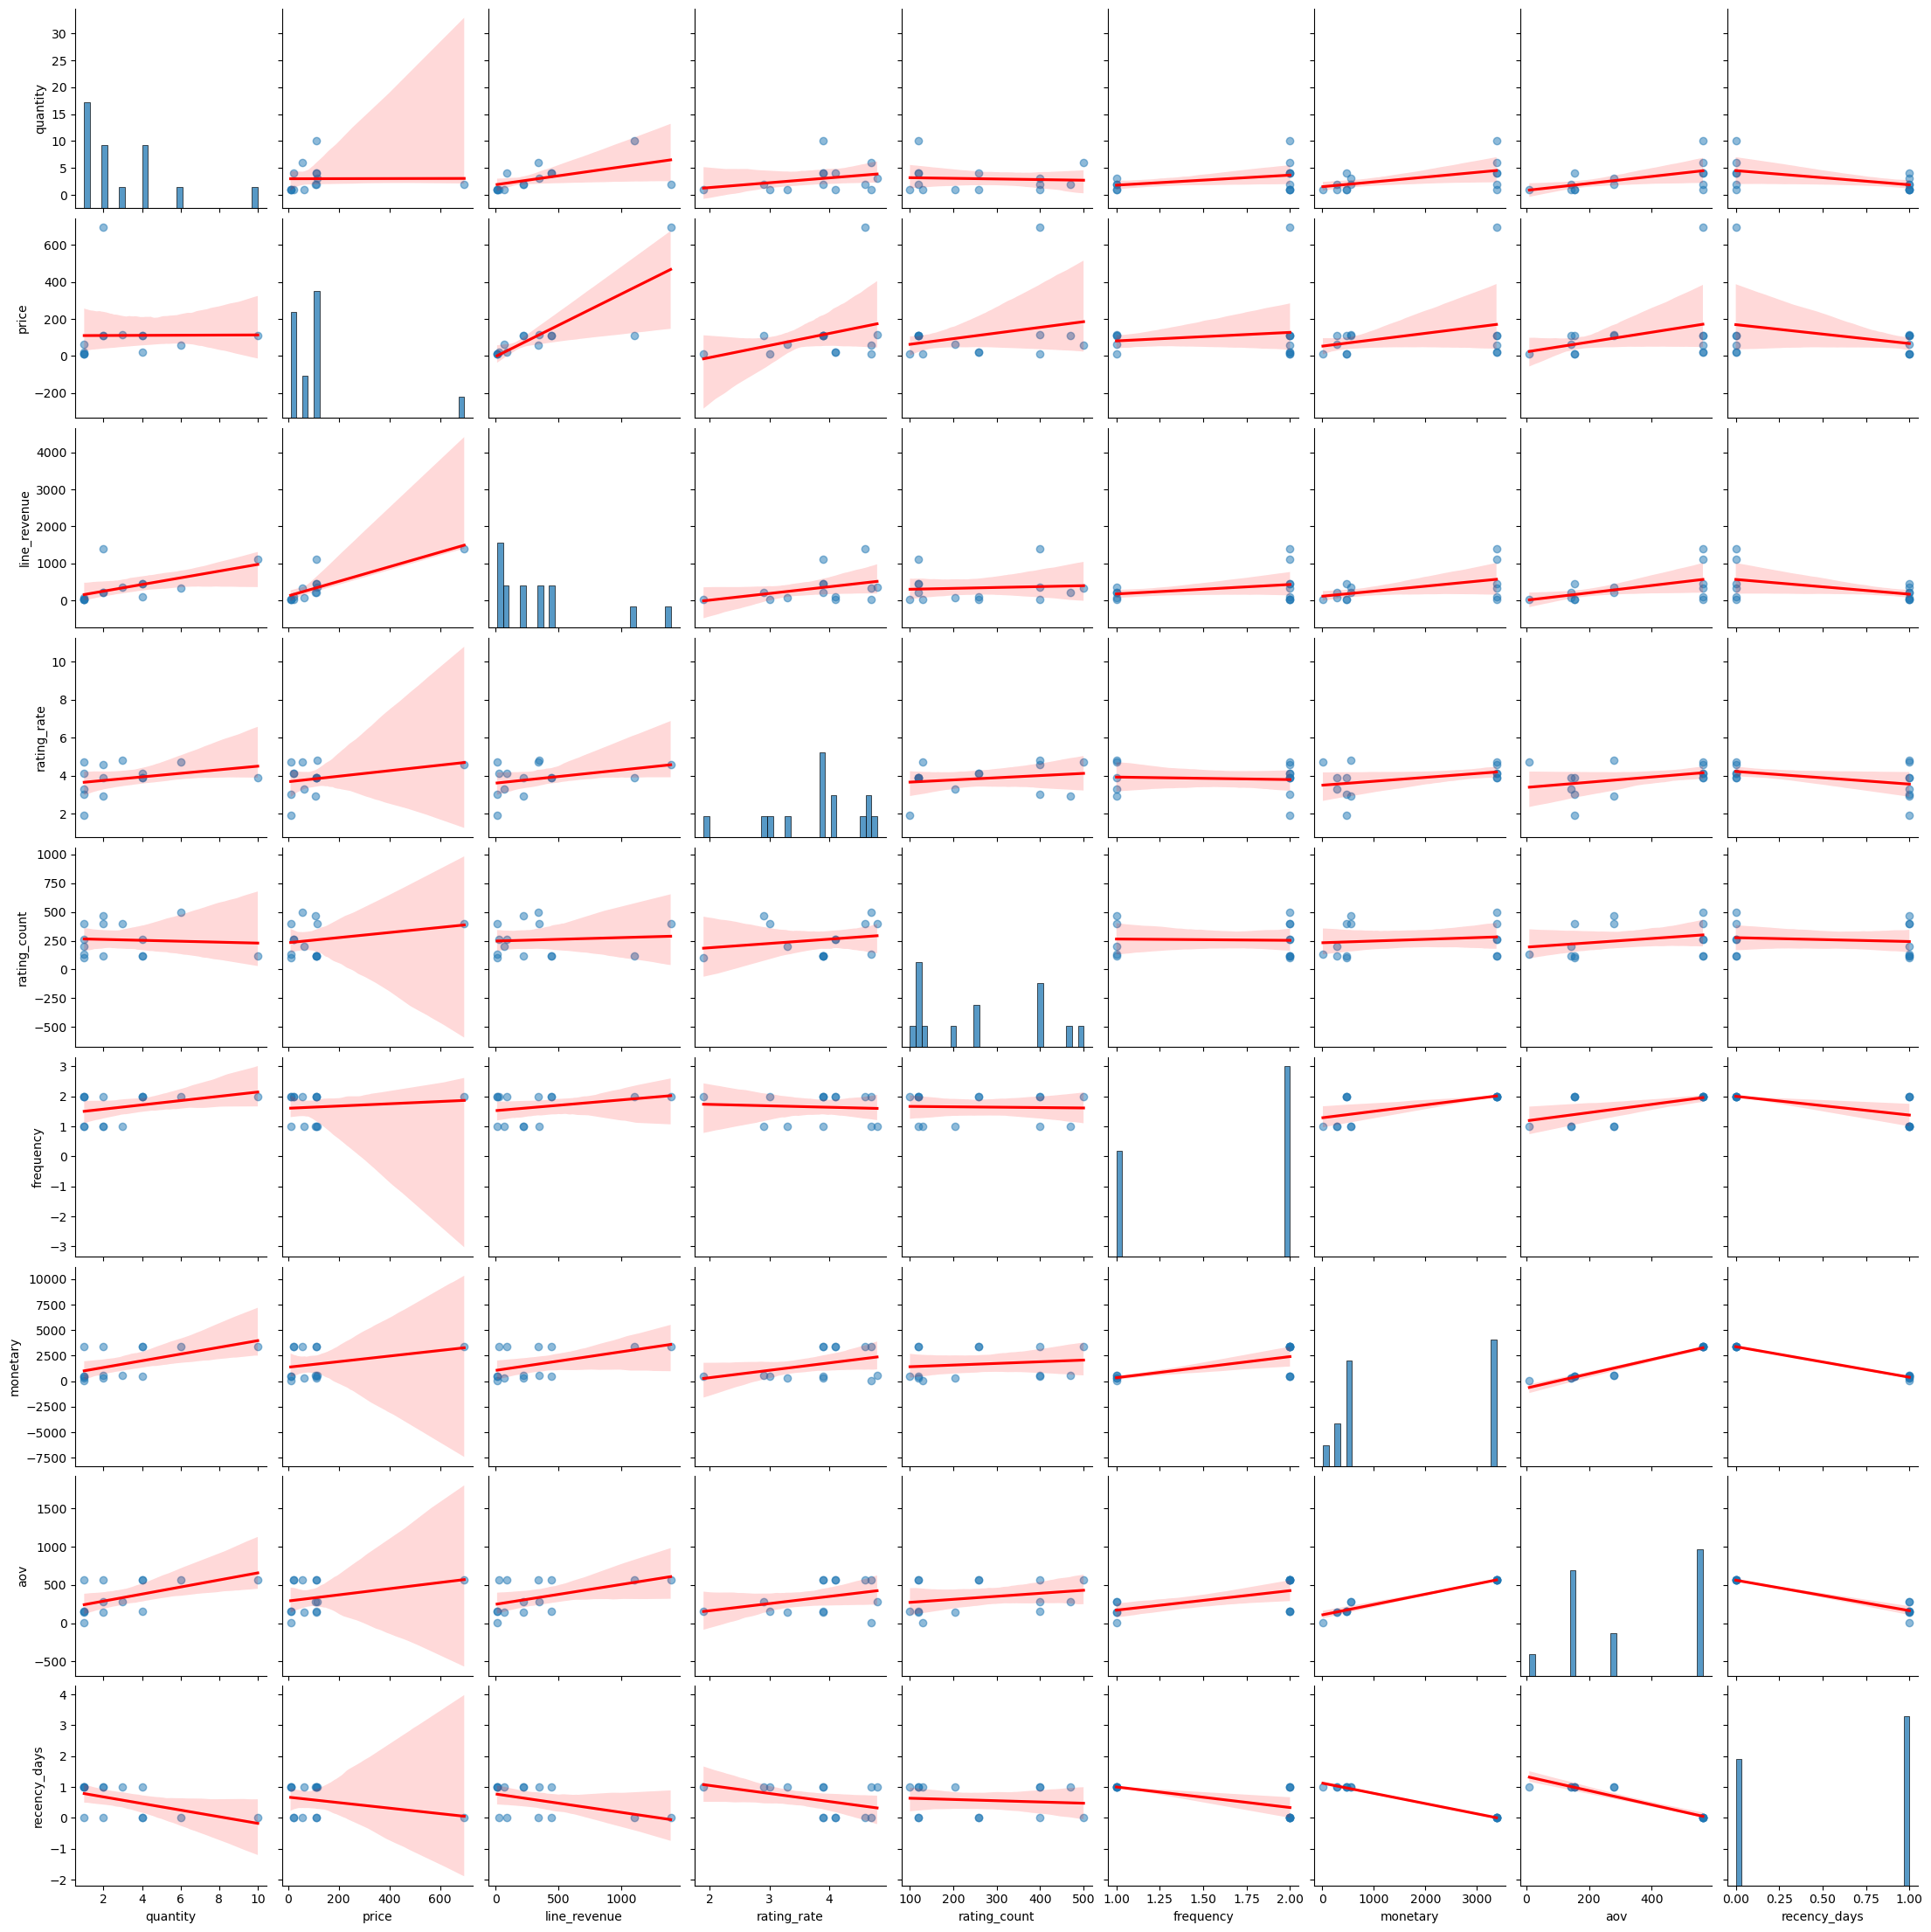

In [453]:
# Pairplot to visualize distributions and relationships, fitted line in scatterplots
sns.pairplot(merge_df[numeric_vars], 
             kind="reg",          # add regression line
             plot_kws={"line_kws":{"color":"red"}, "scatter_kws":{"alpha":0.5}},
             diag_kws={"bins": 30}) 
plt.show()

In [ ]:
# Detect and remove outliers from numeric columns to double check correlations
print("Before removing outliers, data shape:", merge_df.shape)

# store all outlier indices
all_outliers = []

for column in merge_df.select_dtypes(include=[np.number]).columns:
    outliers = detect_outliers_iqr(merge_df, column)
    if not outliers.empty:
        print(f"Outliers detected in '{column}': {outliers.shape[0]} rows")
        all_outliers.extend(outliers.index)

# remove duplicates
all_outliers = set(all_outliers)

# drop all at once
no_outliers_df = merge_df.drop(index=all_outliers).reset_index(drop=True)
print("After removing outliers, data shape:", no_outliers_df.shape)


Before removing outliers, data shape: (14, 19)
Outliers detected in 'user_id': 1 rows
Outliers detected in 'quantity': 1 rows
Outliers detected in 'price': 1 rows
Outliers detected in 'line_revenue': 2 rows
Outliers detected in 'rating_rate': 1 rows
After removing outliers, data shape: (10, 19)


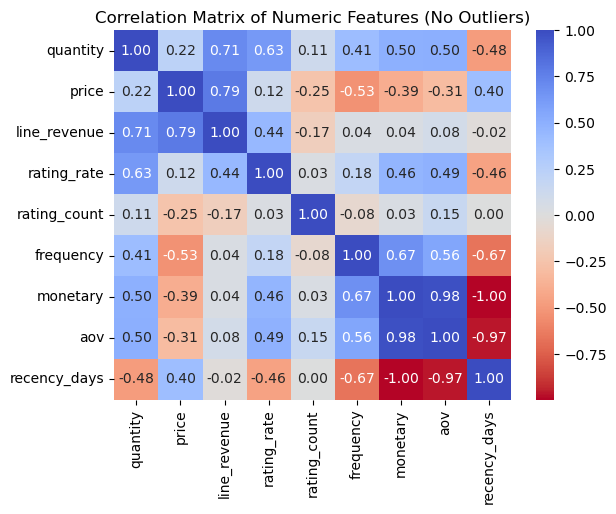

In [ ]:
sns.heatmap(no_outliers_df[numeric_vars].corr(), annot=True, fmt=".2f", cmap="coolwarm_r")
plt.title("Correlation Matrix of Numeric Features (No Outliers)")
plt.show()  

# positive correlation: monetary & frequency (loyal customers spend more)
# negative correlation: recency & frequency/monetary (recent customers spend more)
# negative correlation: recency & aov (recent customers have higher AOV)
# correlations are similar after removing outliers

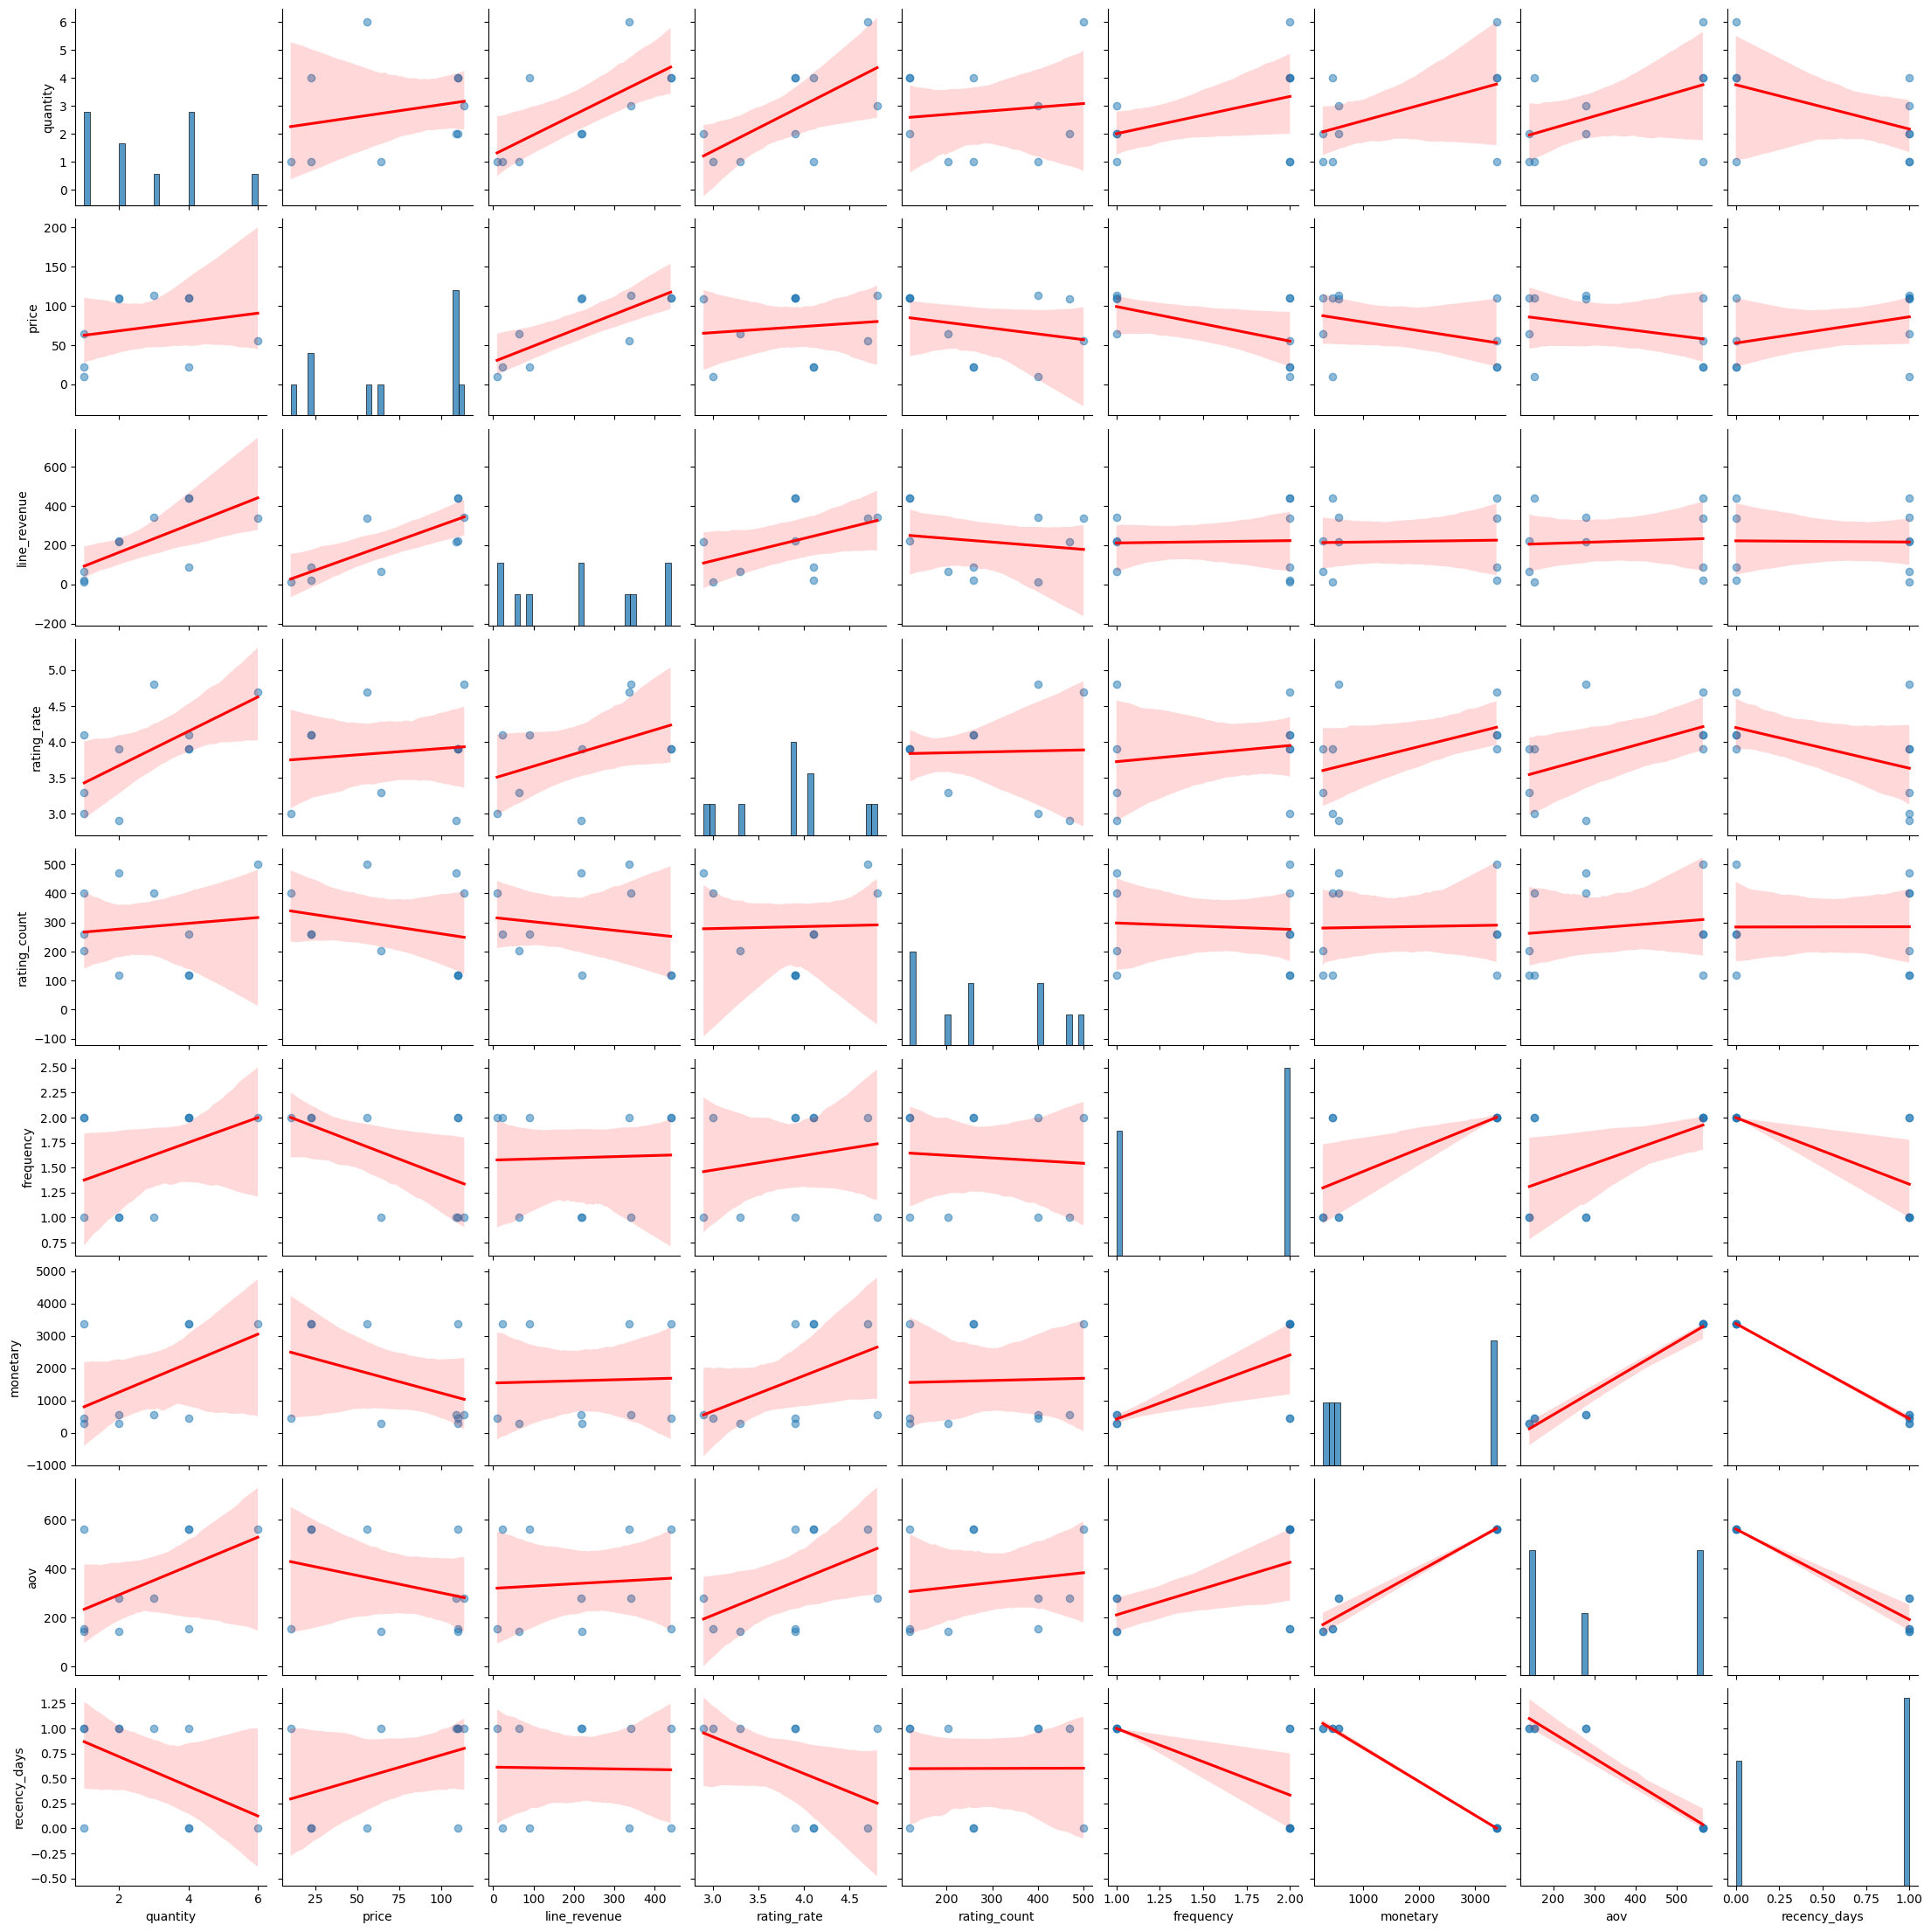

In [462]:
sns.pairplot(no_outliers_df[numeric_vars], 
             kind="reg",          # add regression line
             plot_kws={"line_kws":{"color":"red"}, "scatter_kws":{"alpha":0.5}},
             diag_kws={"bins": 30})
plt.show()

/var/folders/t1/y7l71ql57bqddzsc1430865r0000gn/T/ipykernel_24109/4206927400.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=revenue_by_category, x='category', y='line_revenue', palette='viridis')


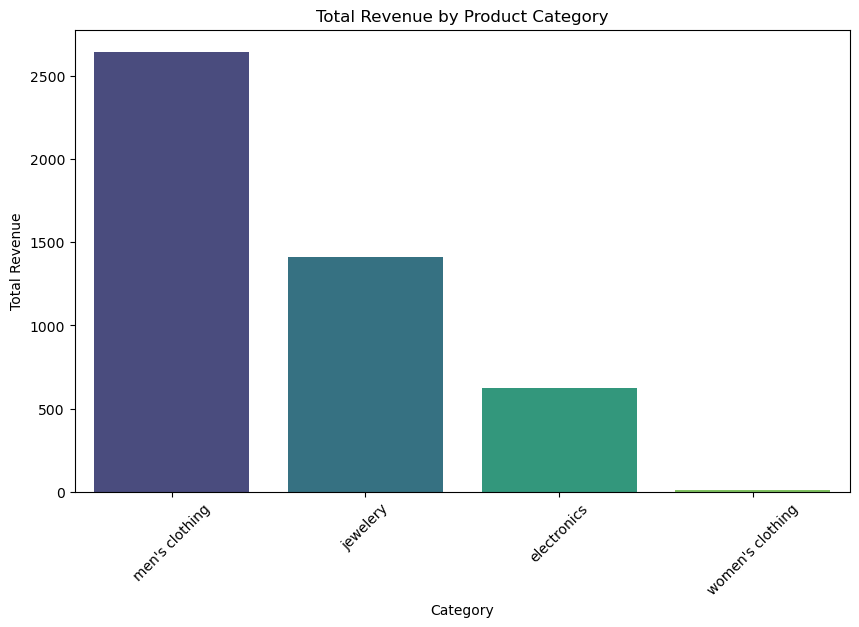

In [455]:
revenue_by_category = merge_df.groupby('category')['line_revenue'].sum().reset_index().sort_values(by='line_revenue', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(data=revenue_by_category, x='category', y='line_revenue', palette='viridis')
plt.title('Total Revenue by Product Category')
plt.xlabel('Category')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()  

/var/folders/t1/y7l71ql57bqddzsc1430865r0000gn/T/ipykernel_24109/1661504331.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merge_df, x='category', y='line_revenue', palette='viridis')


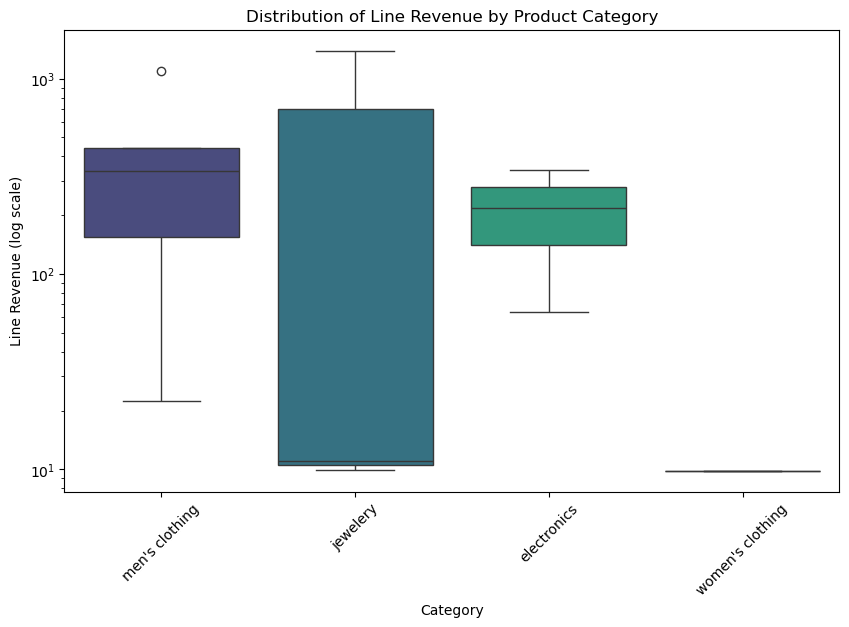

In [456]:
# boxplot to visualize distribution of line_revenue by category
plt.figure(figsize=(10,6))
sns.boxplot(data=merge_df, x='category', y='line_revenue', palette='viridis')
plt.yscale('log')  # Use log scale for better visibility
plt.title('Distribution of Line Revenue by Product Category')
plt.xlabel('Category')
plt.ylabel('Line Revenue (log scale)')
plt.xticks(rotation=45)
plt.show()  

/var/folders/t1/y7l71ql57bqddzsc1430865r0000gn/T/ipykernel_24109/1327852710.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merge_df, x='dayofweek', palette='viridis')


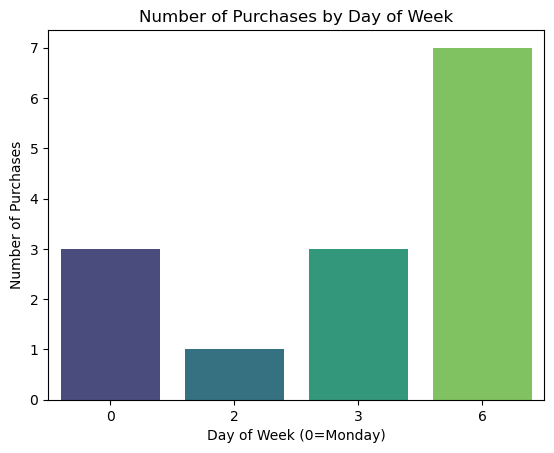

In [457]:
# visualize purchase patterns by day of week
sns.countplot(data=merge_df, x='dayofweek', palette='viridis')
plt.title('Number of Purchases by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Number of Purchases')
plt.show()

/var/folders/t1/y7l71ql57bqddzsc1430865r0000gn/T/ipykernel_24109/3114283385.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merge_df, x='month', palette='viridis')


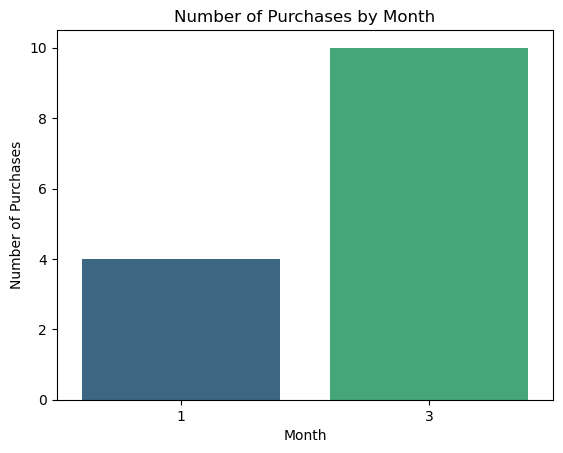

In [458]:
# visualizze purchase patterns by month         
sns.countplot(data=merge_df, x='month', palette='viridis')
plt.title('Number of Purchases by Month')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')
plt.show()

/var/folders/t1/y7l71ql57bqddzsc1430865r0000gn/T/ipykernel_24109/2063256833.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merge_df, x='is_weekend', y='line_revenue', palette='viridis')


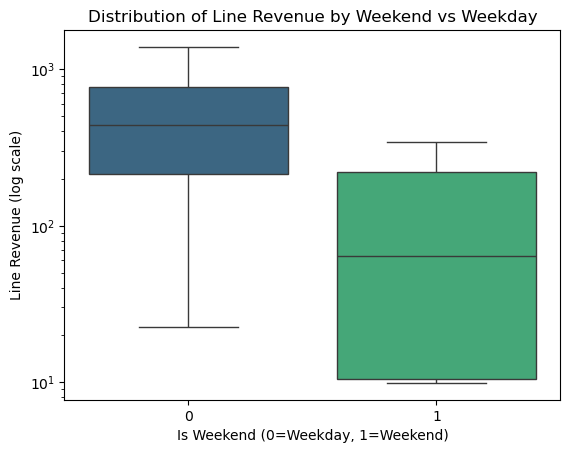

In [459]:
# Visualize distribution of line_revenue by weekend vs weekday  
sns.boxplot(data=merge_df, x='is_weekend', y='line_revenue', palette='viridis')
plt.yscale('log')  # Use log scale for better visibility
plt.title('Distribution of Line Revenue by Weekend vs Weekday')
plt.xlabel('Is Weekend (0=Weekday, 1=Weekend)')
plt.ylabel('Line Revenue (log scale)')
plt.show()

/var/folders/t1/y7l71ql57bqddzsc1430865r0000gn/T/ipykernel_24109/2669166108.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=merge_df, x='dayofweek', palette='viridis', alpha=0.6)


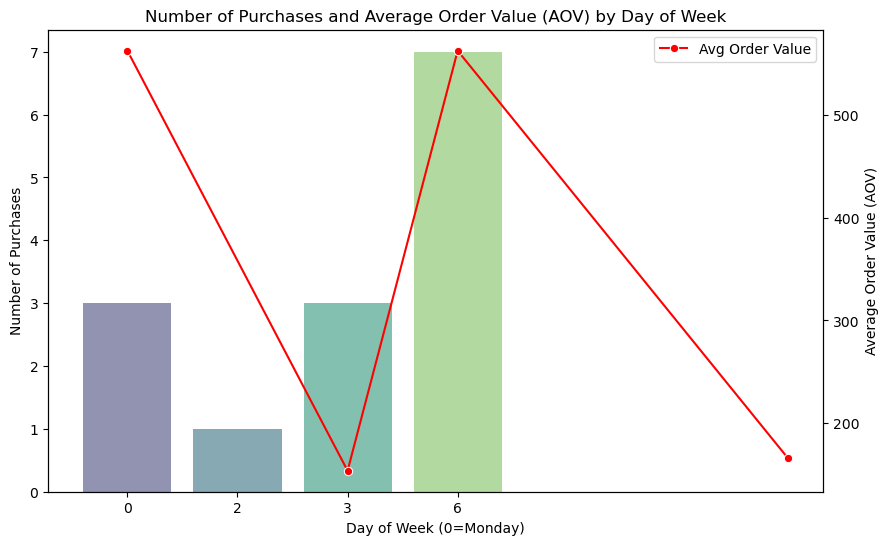

In [460]:
plt.figure(figsize=(10,6))

aov_by_day = merge_df.groupby('dayofweek')['aov'].mean().reset_index().rename(columns={'aov':'avg_aov'})

# Barplot for purchase counts
ax = sns.countplot(data=merge_df, x='dayofweek', palette='viridis', alpha=0.6)
ax.set_ylabel("Number of Purchases")

# Second axis for revenue
ax2 = ax.twinx()
sns.lineplot(data=aov_by_day, x='dayofweek', y='avg_aov', 
             color='red', marker='o', label='Avg Order Value', ax=ax2)
ax2.set_ylabel("Average Order Value (AOV)")

# Titles and legend
ax.set_title("Number of Purchases and Average Order Value (AOV) by Day of Week")
ax.set_xlabel("Day of Week (0=Monday)")
ax2.legend(loc="upper right")

plt.show()
